All topological realated functions are used from the package giotto-tda

Reference: giotto-tda: A Topological Data Analysis Toolkit for Machine Learning and Data Exploration, Tauzin et al, arXiv:2004.02551, 2020.

Some part of the code were take from the tutorials and examples of giotto-tda. Reference: https://giotto-ai.github.io/gtda-docs/latest/notebooks/index.html

In [1]:
# !Run this if giott-tda is not installed
# !pip install giotto-tda
# !pip install keras

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from   scipy import signal
# from keras.models import Sequential
# from keras.layers import Dense,LSTM,Dropout
# from keras.layers.embeddings import Embedding
# from keras.preprocessing import  sequence

In [3]:
print('Loading data ...')
data1 = pd.read_csv('s4_CHAPALTE_hand_s1.csv')		#Loading Accelerometer data
acc_x = data1.acc_x
# sample_rate = len(time_series)/(time_series[len(time_series)-1] - time_series[0])
signal_len = len(acc_x)
print(acc_x.shape)
data2 = pd.read_csv('s4_CHAPALTE_leftear_s1.csv')		#Loading Accelerometer data
acc_x2 = data2.acc_x
acc_x2 = signal.resample(acc_x2, signal_len)
acc_x2.shape

Loading data ...
(5401,)


(5401,)

In [14]:
def sliding_window_seg(data_s, windowSize, windowstep):  # 200Hz data
    data = np.array(data_s)
    w_range = int((len(data) - windowSize + windowstep)/windowstep)
    window_var = []
    a = 0
    b = a + windowSize - 1
    i = 0
    while i < w_range:
        w_data = data[a:b]
        window_var.append(np.var(w_data))
        a = a + windowstep
        b = b + windowstep
        i = i + 1

    window_var = np.array(window_var)
    threshold = 420  # set larger threshold for a more fined segmentation
    var_b = window_var < threshold
    var_b = var_b * 1

    # check whether there are fake pauses, which has pause time < 3 windows (~300ms)
    pauses = []
    pauses_count = 0
    for i in range(len(var_b)):
        if var_b[i] == 1:
            pauses.append(i)
        else:
            if 0 < len(pauses) <= 3:
                var_b[pauses] = 0
                pauses_count += 1
            pauses = []

    print('Detected and removed {} fake pauses'.format(pauses_count))
    segment = {}  # segment data where number of (var_b == 0) > 500ms
    seg_point = []
    count = 0
    for i in range(len(var_b)):
        # print(var_b[i])
        if var_b[i] == 0:
            seg_point.append(i)
        else:
            if seg_point:
                count += 1
                segment[count] = seg_point
                seg_point = []

    if var_b[-1] == 0:
        count += 1
        segment[count] = seg_point

    start_end = []
    for i in range(len(segment)):
        seg = np.array(segment[i+1])
        if len(seg) > 5:  #around 300ms
            start = seg[0] * windowstep
            end = seg[-1] * windowstep + windowSize - 1
            start_end.append([start, end])

    return start_end, threshold

In [17]:
#sp,th = sliding_window_seg(acc_x, 30, 15)#(acc_x)
sp,th = sliding_window_seg(acc_x, 30, 10)
print(sp, len(sp))

Detected and removed 0 fake pauses
[[420, 909], [890, 1379], [1400, 1889], [1960, 2429], [2420, 2909], [2890, 3369], [3350, 3809], [3810, 4709], [4720, 5239]] 9


0


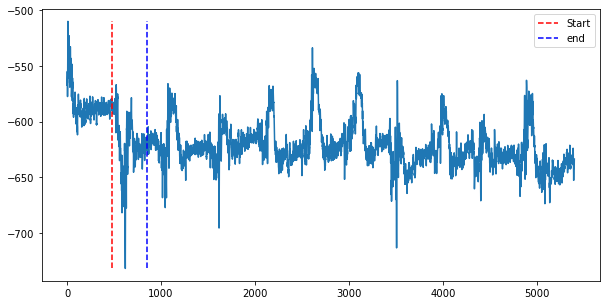

1


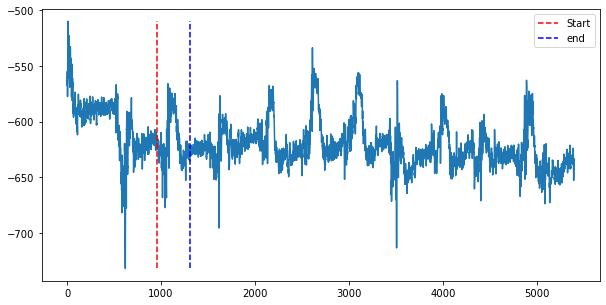

2


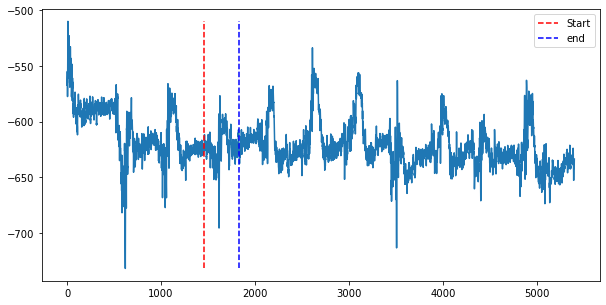

3


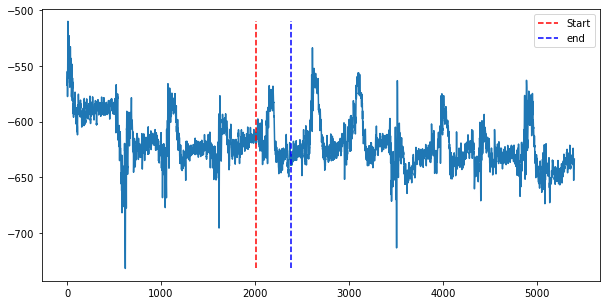

4


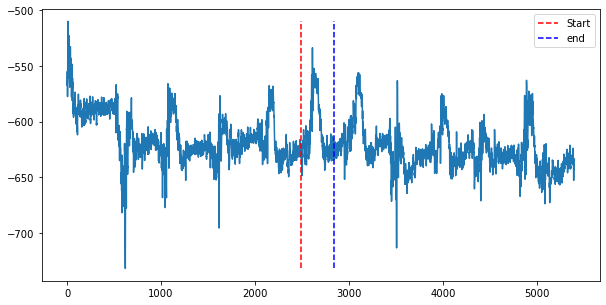

5


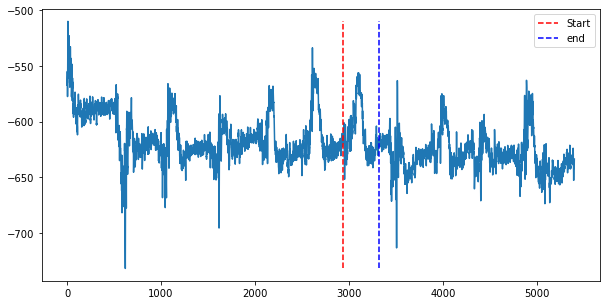

6


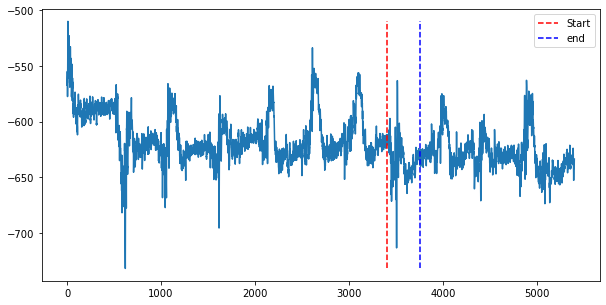

7


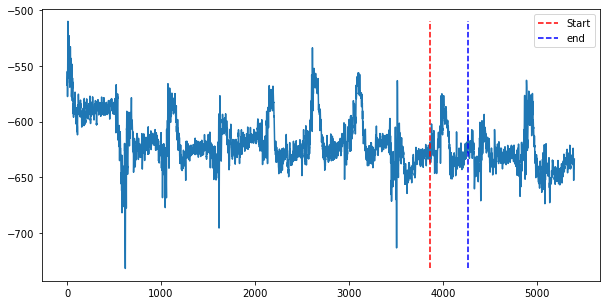

8


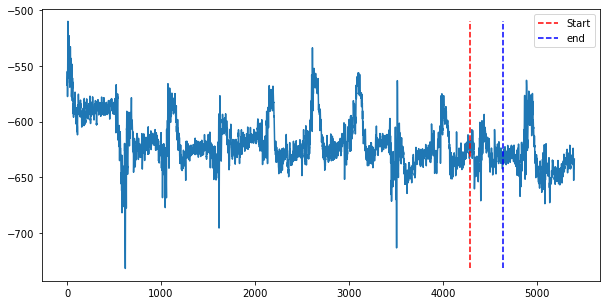

9


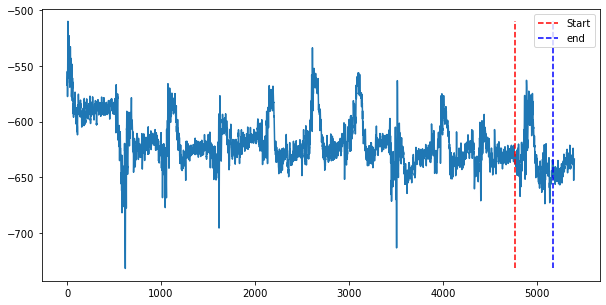

In [16]:
data       = acc_x2
seg_points = sp
axis_x     = None
axis_x = np.arange(0, len(data))
for i in range(len(seg_points)):
    print(i)
    if axis_x is None:
        axis_x = np.arange(0, len(data))
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(axis_x, data)
    ax.vlines(axis_x[seg_points[i][0]], min(data), max(data), 'r', 'dashed', label='Start')
    ax.vlines(axis_x[seg_points[i][1]], min(data), max(data), 'b', 'dashed', label='end')
    plt.legend()
    plt.show()

In [9]:
def stft(self, sig=None, sf=256, seg_p=32):
    if sig is None:
        sig = self.filtered
        
    # plt.plot(self.data)
    # plt.show()
    # plt.plot(sig)
    # plt.show()
    f, t, Zxx = signal.stft(sig, sf, nperseg=seg_p)
    return f, t, Zxx

    def plot_stft(self, t, f, z):
        plt.pcolormesh(t, f, np.abs(z), shading='gouraud')
        plt.title('STFT Magnitude')
        plt.ylabel('Frequency [Hz]')
        plt.xlabel('Time [sec]')
        plt.show()

Last login: Fri May 27 13:27:08 on ttys003

The default interactive shell is now zsh.
To update your account to use zsh, please run `chsh -s /bin/zsh`.
For more details, please visit https://support.apple.com/kb/HT208050.
(base) Xinxings-MacBook-Pro-779:RECOGASL YJ$ cd
(base) Xinxings-MacBook-Pro-779:~ YJ$ cd Downloads/
(base) Xinxings-MacBook-Pro-779:Downloads YJ$ ls
Human-Activity-Recognition-main		Human-Activity-Recognition-master	Human-Activity-Recognition-master.zip
Human-Activity-Recognition-main.zip	Human-Activity-Recognition-master 2
(base) Xinxings-MacBook-Pro-779:Downloads YJ$ vim features.py 
(base) Xinxings-MacBook-Pro-779:Downloads YJ$ vim features.py 

















        min_len = len(sig[0])
        for i in range(sig_len):
            psig = sig[i]
            # psig = self.lp_filter(sf, 14, sig=psig)
            len_seg = int(sf/2)
            if len(psig[1:]) < len_seg:
                return None
            # elif len(psig[1:]) < len_seg:
            #     len_seg /= 2
            f, t, Z = self.stft(psig[1:], sf, len_seg)
            # f, t, Z = self.stft(psig[1:], fps, 16)
            # tmp = np.abs(Z[0:max_f_idx, :])
            tmp = np.abs(Z)
            # print('max t is: ')
            # print(np.max(t))
            # print('max f is: ')
            # print(f[max_f_idx])
            # psig_f.append(f[:max_f_idx])
            # psig_t.append(t)
            min_len = len(t)
            # if min_len > tmp_len:
            #     min_len = tmp_len
            psig_m.append(tmp)
        # psig_m_c = []
        # for i in psig_m:
        #     psig_m_c.append(i[:, 0:min_len])    # 1, 2, 3
        psig_m_m = np.array(psig_m[0])
        for i in range(len(psig_m)-1):
            psig_m_m = np.concatenate((psig_m_m, np.array(psig_m[i+1])), axis=0)    # 1, 2, 3
        # psig_m_m = scale(psig_m_m, )
        width = min_len / max_f_idx * 5
        # print(width)
        if plot:
            fig, ax = plt.subplots(frameon=False, figsize=(width, 4), dpi=100)
            # t = np.array(np.max(psig_m_m))
            ax.pcolormesh(psig_m_m, shading='gouraud', vmax=vmax)
            # ax.set_title('STFT Magnitude')
            # ax.set_ylabel('Frequency [Hz]')
            # ax.set_xlabel('Time [sec]')
            plt.axis('off')
            # ax.set_aspect(max_f_idx/(2*min_len))
            # ax.set_ylim(0, 6*max_f_idx)
        plt.show()
        if save_to_file:
            fig.savefig(save_to_file, transparent=True, bbox_inches='tight', pad_inches = 0)
            plt.close(fig)
        return psig_m_m











SyntaxError: invalid syntax (1822888500.py, line 19)

In [9]:
# #Some useful global variables
# noofsubjects = 51
# noofactivities = 18
# activity_labels = np.append(range(1, 14), range(15, 20)) #class labels
# segmentsize=400 #window size of time series data (20 seconda)
# cols = ["tree_accuracy", "forest_accuracy", "kn_accuracy", 
#         "tree_recall", "forest_recall", "kn_recall",
#         "tree_precision", "forest_precision", "kn_precision",
#         "tree_f1", "foresh_ft", "kn_f1"]

In [10]:
# #persistance diagram object in homology dimension 0 and 1
# persistence = CubicalPersistence(homology_dimensions=[0, 1], n_jobs=-1)

# #scale
# scaling = Scaler()

# #steps in the pipele - configuratble
# steps = [("persistence", persistence),
#          ("scaling", scaling), 
#          ]

# topological_transfomer = Pipeline(steps)

In [11]:
# def generate_time_segments(filepath):
#     '''
#     Generates segmented data from the raw data for all 51 subjects
#     '''
#     inputarr=[] #input
#     output=[] #output labels
#     subjectid_arr=[] #array of subject ids
        
#     #get filesname of the data files
#     files=read_filenames(filepath)
    
#     #loop through all 51 subjects
#     for subjectid, file in enumerate(files):
#         data = pd.read_csv(file)
        
#         #loop through each activity and get data
#         for class_label in  activity_labels:
#             #get data for each activity
#             rawdata=np.array(data.loc[data['activity']==chr(class_label+64), ['X','Y', 'Z']])
              
#             #if no data exists for the activity skip and continue
#             if rawdata.size <= 0:
#                 continue
        
#             #no of samples of size=segment size
#             #rawdata=scaler.fit_transform(rawdata)
#             samples = math.floor(rawdata.shape[0]/segmentsize)
        
#             #loop through the segments
#             start=0
#             for i in range(samples):
#                 segmenteddata=rawdata[start:(start+segmentsize)]
              
#                 #break the look if data size < segment size 
#                 if segmenteddata.shape[0] < segmentsize:
#                     break;
            
#                 #Perform time delay embedding with embedding dimension=3
#                 embedded_data=np.column_stack([
#                     segmenteddata[0:-2,:],
#                     segmenteddata[1:-1,:],
#                     segmenteddata[2:,:],
#                 ])
                
#                 inputarr.append(embedded_data)
#                 output.append(class_label)
#                 subjectid_arr.append(subjectid)
            
#                 start += segmentsize
    
#     return np.array(inputarr), np.array(subjectid_arr), np.array(output)

In [12]:
# def generate_topological_features(inputarr, nbins=50):
#     '''
#     Generates persistance homology for the the raw data in segmentsize windows.
#     Extract topological features out of the persistance homology diagrams
#     '''
#     #topological feature extracted from persistance homology
#     entropy=  PersistenceEntropy(n_jobs=-1, normalize=True)
#     landscape=Amplitude(metric="landscape", n_jobs=-1, metric_params={"n_bins":nbins})
#     wasserstein=Amplitude(metric="wasserstein", n_jobs=-1)
#     betti=Amplitude(metric="betti", n_jobs=-1, metric_params={"n_bins":nbins})
#     bottleneck=Amplitude(metric="bottleneck", n_jobs=-1)
#     p_image=Amplitude(metric="persistence_image", n_jobs=-1, metric_params={"n_bins":nbins})
#     heat=Amplitude(metric="heat", n_jobs=-1, metric_params={"n_bins":nbins})
#     silhouette=Amplitude(metric="silhouette", n_jobs=-1, metric_params={"n_bins":nbins})
#     noofpoints=NumberOfPoints(n_jobs=-1)

#     #generate persistance homology diagram
#     features = topological_transfomer.fit_transform(inputarr)
    
#     #extract topological features
#     features_array=np.column_stack([
#             entropy.fit_transform(features),
#             landscape.fit_transform(features),
#             wasserstein.fit_transform(features),
#             betti.fit_transform(features),
#             bottleneck.fit_transform(features),
#             p_image.fit_transform(features),
#             heat.fit_transform(features),
#             silhouette.fit_transform(features),
#             noofpoints.fit_transform(features),       
#     ])

#     return features_array


In [13]:
# def generate_features(inputarr, subject, output, nbins):
#     '''
#     Generate topological features for the input
#     '''
#     features = np.empty((0,18), float)
#     class_label=np.empty((0,1), int)
#     subject_label = np.empty((0,1), int)
    
#     for subjectid in range(51):
#         print("Processing subject %i"%subjectid)
#         X = inputarr[subject==subjectid]
#         y = output[subject==subjectid]
        
#         if X.shape[0] == 0:
#             continue;
            
#         #generate topological features
#         features = np.append(features, generate_topological_features(X, nbins), axis=0)
#         class_label = np.append(class_label, y)
#         subject_label = np.append(subject_label, np.full((X.shape[0], 1), subjectid, int))
    
#     return features, class_label, subject_label

In [14]:
# def impersonal_model(features, class_label, subject_label):
#     '''
#     Trains impersonal nodel for the toplogical features.
#     Classifiers trained - decision tree, random forest and k neighbours
#     '''
#     tree_model=[]
#     forest_model=[]
#     kn_model=[]
#     X_tst=[]
#     y_tst=[]
#     scaler = preprocessing.StandardScaler()
    
#     #loop through all 51 subjects
#     for subjectid in range(51):
#         #LOSO validation
#         print("Validating subject %i"%subjectid)
#         X_train = features[subject_label!=subjectid]
#         y_train = class_label[subject_label!=subjectid]
#         X_test = features[subject_label==subjectid] 
#         y_test = class_label[subject_label==subjectid]
        
#         #shuffle training samples
#         X_train, y_train = shuffle(X_train, y_train)
        
#         #schale the features
#         X_train=scaler.fit_transform(X_train)
#         X_test=scaler.transform(X_test)
    
#         #train the model
#         forest = RandomForestClassifier(random_state=0)
#         tree = DecisionTreeClassifier(random_state=0)
#         kneighbors=KNeighborsClassifier()
        
#         #fit the models
#         forest.fit(X_train, y_train)
#         tree.fit(X_train, y_train)
#         kneighbors.fit(X_train, y_train)
        
#         tree_model.append(tree)
#         forest_model.append(forest)
#         kn_model.append(kneighbors)
#         X_tst.append(X_test)
#         y_tst.append(y_test)
        
#     return tree_model, forest_model, kn_model, X_tst, y_tst

In [15]:
# def personal_model(features, class_label, subject_label):
#     '''
#     Trains personal nodel for the toplogical features.
#     Classifiers trained - decision tree, random forest and k neighbours
#     '''
#     tree_model=[]
#     forest_model=[]
#     kn_model=[]
#     X_tst=[]
#     y_tst=[]
#     scaler = preprocessing.StandardScaler()
    
#     #loop through all 51 subjects
#     for subjectid in range(51):
#         print("Processing subject %i"%subjectid)
#         X = features[subject_label==subjectid]
#         y = class_label[subject_label==subjectid]
        
#         #split the data
#         X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

#         #schale the features
#         X_train=scaler.fit_transform(X_train)
#         X_test=scaler.transform(X_test)
        
#         #train the model
#         forest = RandomForestClassifier(random_state=0)
#         tree = DecisionTreeClassifier(random_state=0)
#         kneighbors=KNeighborsClassifier()
        
#         #fit the models
#         forest.fit(X_train, y_train)
#         tree.fit(X_train, y_train)
#         kneighbors.fit(X_train, y_train)
        
#         tree_model.append(tree)
#         forest_model.append(forest)
#         kn_model.append(kneighbors)
#         X_tst.append(X_test)
#         y_tst.append(y_test)
        
#     return tree_model, forest_model, kn_model, X_tst, y_tst

In [16]:
#calculate avg
# def calculate_score(tree_model, forest_model, kn_model, X_tst, y_tst):
#     '''
#     Evaluates the model and return the average metric scores
#     '''
#     #initialize to np.nan to handle missing subjects and activities
#     #use np.nanmean to ignore nan values
#     noOfSubjects = len(tree_model)
#     recall_score=np.full([3, noOfSubjects,18], np.nan)
#     precision_score=np.full([3, noOfSubjects,18], np.nan)
#     f1_score= np.full([3, noOfSubjects,18], np.nan)
#     accuracy=np.full([3, noOfSubjects,18], np.nan)
#     overall_accuracy = np.full([3, noOfSubjects], np.nan)
    
#     for subjectid, X_test in enumerate(X_tst):
#         if len(X_test) == 0:
#             continue
#         for i, clf in enumerate([tree_model[subjectid], forest_model[subjectid], kn_model[subjectid]]):
#             y_pred = clf.predict(X_test)
#             with np.errstate(divide='ignore', invalid='ignore'):
#                 recall_score[i][subjectid] = sklearn.metrics.recall_score(y_tst[subjectid], y_pred, average=None, labels=activity_labels, zero_division=0)
#                 precision_score[i][subjectid] = sklearn.metrics.precision_score(y_tst[subjectid], y_pred, average=None, labels=activity_labels, zero_division=0)
#                 f1_score[i][subjectid] = sklearn.metrics.f1_score(y_tst[subjectid], y_pred, average=None, labels=activity_labels, zero_division=0)
#                 cm = sklearn.metrics.confusion_matrix(y_tst[subjectid], y_pred, labels=activity_labels)
#                 accuracy[i][subjectid] = cm.diagonal()/cm.sum(axis=1)
#                 overall_accuracy[i][subjectid] = sklearn.metrics.accuracy_score(y_tst[subjectid], y_pred)

#     score = np.column_stack([np.nanmean(accuracy, axis=1).T, 
#                              np.nanmean(recall_score, axis=1).T, 
#                              np.nanmean(precision_score, axis=1).T, 
#                              np.nanmean(f1_score, axis=1).T]) * 100
    
#     return score, np.nanmean(overall_accuracy, axis=1)


In [17]:
#get all time segments from each sensors
# phone_accel_input, phone_accel_subjectid, phone_accel_output = generate_time_segments("phone/accel/")
# phone_gyro_input, phone_gyro_subjectid, phone_gyro_output = generate_time_segments("phone/gyro/")
# watch_accel_input, watch_accel_subjectid, watch_accel_output = generate_time_segments("watch/accel/")
# watch_gyro_input, watch_gyro_subjectid, watch_gyro_output = generate_time_segments("watch/gyro/")

In [18]:
# print("Phone accel: input %s subcjectid %s output %s"%(np.shape(phone_accel_input), np.shape(phone_accel_subjectid), np.shape(phone_accel_output)))
# print("Phone gyro: input %s subcjectid %s output %s"%(np.shape(phone_gyro_input), np.shape(phone_gyro_subjectid), np.shape(phone_gyro_output)))
# print("Watch accel: input %s subcjectid %s output %s"%(np.shape(watch_accel_input), np.shape(watch_accel_subjectid), np.shape(watch_accel_output)))
# print("Watch gyro: input %s subcjectid %s output %s"%(np.shape(watch_gyro_input), np.shape(watch_gyro_subjectid), np.shape(watch_gyro_output)))

In [19]:
#generate features for phone accel 
# (phone_accel_features, phone_accel_class_label, phone_accel_subject) = generate_features(
#      phone_accel_input, 
#      phone_accel_subjectid, 
#      phone_accel_output, nbins=100)

# print(phone_accel_features.shape)
# print(phone_accel_class_label.shape)
# print(phone_accel_subject.shape)
# write_to_file((phone_accel_features, phone_accel_class_label, phone_accel_subject), "phone_accel_features")

In [20]:
# #generate features for phone gyro 
# (phone_gyro_features, phone_gyro_class_label, phone_gyro_subject) = generate_features(
#      phone_gyro_input, 
#      phone_gyro_subjectid, 
#      phone_gyro_output, nbins=100)

# print(phone_gyro_features.shape)
# print(phone_gyro_class_label.shape)
# print(phone_gyro_subject.shape)

# write_to_file((phone_gyro_features, phone_gyro_class_label, phone_gyro_subject), "phone_gyro_features")

In [21]:
#generate features for watch accel 
# (watch_accel_features, watch_accel_class_label, watch_accel_subject) = generate_features(
#      watch_accel_input, 
#      watch_accel_subjectid, 
#      watch_accel_output, nbins=100)

# print(watch_accel_features.shape)
# print(watch_accel_class_label.shape)
# print(watch_accel_subject.shape)
# write_to_file((watch_accel_features, watch_accel_class_label, watch_accel_subject), "watch_accel_features")

In [22]:
#generate features for watch gyro 
# (watch_gyro_features, watch_gyro_class_label, watch_gyro_subject) = generate_features(
#      watch_gyro_input, 
#      watch_gyro_subjectid, 
#      watch_gyro_output, nbins=100)

# print(watch_gyro_features.shape)
# print(watch_gyro_class_label.shape)
# print(watch_gyro_subject.shape)
# write_to_file((watch_gyro_features, watch_gyro_class_label, watch_gyro_subject), "watch_gyro_features")

In [23]:
# #generate personal models for phone accel 
# (phone_accel_tree_model, 
#  phone_accel_forest_model, 
#  phone_accel_kn_model, 
#  phone_accel_X_tst, 
#  phone_accel_y_tst) = personal_model(phone_accel_features, phone_accel_class_label, phone_accel_subject)

# write_to_file((phone_accel_tree_model, 
#                phone_accel_forest_model, 
#                phone_accel_kn_model, 
#                phone_accel_X_tst, 
#                phone_accel_y_tst), "phone_accel_personal_model")


In [24]:
#generate personal models for phone gyro and classfiy using it
# (phone_gyro_tree_model, 
#  phone_gyro_forest_model, 
#  phone_gyro_kn_model, 
#  phone_gyro_X_tst, 
#  phone_gyro_y_tst) = personal_model(phone_gyro_features, phone_gyro_class_label, phone_gyro_subject)


# write_to_file((phone_gyro_tree_model, 
#                phone_gyro_forest_model, 
#                phone_gyro_kn_model, 
#                phone_gyro_X_tst, 
#                phone_gyro_y_tst), "phone_gyro_personal_model")


In [25]:
# #generate personal models for watch accel and classfiy using it
# (watch_accel_tree_model, 
#  watch_accel_forest_model, 
#  watch_accel_kn_model, 
#  watch_accel_X_tst, 
#  watch_accel_y_tst) = personal_model(watch_accel_features, watch_accel_class_label, watch_accel_subject)

# write_to_file((watch_accel_tree_model, 
#                watch_accel_forest_model, 
#                watch_accel_kn_model, 
#                watch_accel_X_tst, 
#                watch_accel_y_tst), "watch_accel_personal_model")

In [26]:
#generate personal models for watch gyro and classfiy using it
# (watch_gyro_tree_model, 
#  watch_gyro_forest_model, 
#  watch_gyro_kn_model, 
#  watch_gyro_X_tst, 
#  watch_gyro_y_tst) = personal_model(watch_gyro_features, watch_gyro_class_label, watch_gyro_subject)

# write_to_file((watch_gyro_tree_model, 
#                watch_gyro_forest_model, 
#                watch_gyro_kn_model, 
#                watch_gyro_X_tst, 
#                watch_gyro_y_tst), "watch_gyro_personal_model")

In [27]:
#calculate personal model accuracy scores

# phone_accel_score_personal = calculate_score(phone_accel_tree_model, 
#                                    phone_accel_forest_model, 
#                                    phone_accel_kn_model, 
#                                    phone_accel_X_tst, 
#                                    phone_accel_y_tst)

# phone_gyro_score_personal = calculate_score(phone_gyro_tree_model, 
#                                    phone_gyro_forest_model, 
#                                    phone_gyro_kn_model, 
#                                    phone_gyro_X_tst, 
#                                    phone_gyro_y_tst)

# watch_accel_score_personal = calculate_score(watch_accel_tree_model, 
#                                    watch_accel_forest_model, 
#                                    watch_accel_kn_model, 
#                                    watch_accel_X_tst, 
#                                    watch_accel_y_tst)

# watch_gyro_score_personal = calculate_score(watch_gyro_tree_model, 
#                                    watch_gyro_forest_model, 
#                                    watch_gyro_kn_model, 
#                                    watch_gyro_X_tst, 
#                                    watch_gyro_y_tst)


In [28]:
#generate impersonal models for phone accel 
# (phone_accel_tree_impersonal_model, 
#  phone_accel_forest_impersonal_model, 
#  phone_accel_kn_impersonal_model, 
#  phone_accel_impersonal_X_tst, 
#  phone_accel_impersonal_y_tst) = impersonal_model(phone_accel_features, phone_accel_class_label, phone_accel_subject)

In [29]:
#generate impersonal models for phone gyro 
# (phone_gyro_tree_impersonal_model, 
#  phone_gyro_forest_impersonal_model, 
#  phone_gyro_kn_impersonal_model, 
#  phone_gyro_impersonal_X_tst, 
#  phone_gyro_impersonal_y_tst) = impersonal_model(phone_gyro_features[:,:18], phone_gyro_class_label, phone_gyro_subject)

In [30]:
# #generate impersonal models for watch accel 
# (watch_accel_tree_impersonal_model, 
#  watch_accel_forest_impersonal_model, 
#  watch_accel_kn_impersonal_model, 
#  watch_accel_impersonal_X_tst, 
#  watch_accel_impersonal_y_tst) = impersonal_model(watch_accel_features, watch_accel_class_label, watch_accel_subject)

In [31]:
#generate impersonal models for watch gyro 
# (watch_gyro_tree_impersonal_model, 
#  watch_gyro_forest_impersonal_model, 
#  watch_gyro_kn_impersonal_model, 
#  watch_gyro_impersonal_X_tst, 
#  watch_gyro_impersonal_y_tst) = impersonal_model(watch_gyro_features, watch_gyro_class_label, watch_gyro_subject)


In [32]:
#calculate scores for impersonal model
# phone_accel_score_impersonal = calculate_score(phone_accel_tree_impersonal_model, 
#                                      phone_accel_forest_impersonal_model, 
#                                      phone_accel_kn_impersonal_model, 
#                                      phone_accel_impersonal_X_tst, 
#                                      phone_accel_impersonal_y_tst)


# phone_gyro_score_impersonal = calculate_score(phone_gyro_tree_impersonal_model, 
#                                          phone_gyro_forest_impersonal_model, 
#                                          phone_gyro_kn_impersonal_model, 
#                                          phone_gyro_impersonal_X_tst, 
#                                          phone_gyro_impersonal_y_tst)

# watch_accel_score_impersonal = calculate_score(watch_accel_tree_impersonal_model, 
#                                      watch_accel_forest_impersonal_model, 
#                                      watch_accel_kn_impersonal_model, 
#                                      watch_accel_impersonal_X_tst, 
#                                      watch_accel_impersonal_y_tst)
        
# watch_gyro_score_impersonal = calculate_score(watch_gyro_tree_impersonal_model, 
#                                      watch_gyro_forest_impersonal_model, 
#                                      watch_gyro_kn_impersonal_model, 
#                                      watch_gyro_impersonal_X_tst, 
#                                      watch_gyro_impersonal_y_tst)                        

In [33]:
# pd.DataFrame(np.around(phone_accel_score_personal[0], 1), columns=cols)

In [34]:
# pd.DataFrame(np.around(phone_gyro_score_personal[0], 1), columns=cols)

In [35]:
# pd.DataFrame(np.around(watch_accel_score_personal[0], 1), columns=cols)

In [36]:
# pd.DataFrame(np.around(watch_gyro_score_personal[0], 1), columns=cols)

In [37]:
# pd.DataFrame(np.around(phone_accel_score_impersonal[0], 1), columns=cols)

In [38]:
# pd.DataFrame(np.around(phone_gyro_score_impersonal[0], 1), columns=cols)

In [39]:
# pd.DataFrame(np.around(watch_accel_score_impersonal[0], 1), columns=cols)

In [40]:
# pd.DataFrame(np.around(watch_gyro_score_impersonal[0], 1), columns=cols)

In [41]:
# #write splitted time segments to file for later use
# write_to_file({"input": phone_accel_input, "subject":phone_accel_subjectid, "output":phone_accel_output}, "phone_accel_200")
# write_to_file({"input": phone_gyro_input, "subject":phone_gyro_subjectid, "output":phone_gyro_output}, "phone_gyro_200")
# write_to_file({"input": watch_accel_input, "subject":watch_accel_subjectid, "output":watch_accel_output}, "watch_accel_200")
# write_to_file({"input": watch_gyro_input, "subject":watch_gyro_subjectid, "output":watch_gyro_output}, "watch_gyro_200")

In [42]:
# #read data file from pickle dumps if required
# data=read_from_file("phone_accel_400")
# phone_accel_input, phone_accel_subjectid, phone_accel_output = data["input"], data["subject"], data["output"]

# data=read_from_file("phone_gyro_400")
# phone_gyro_input, phone_gyro_subjectid, phone_gyro_output =  data["input"], data["subject"], data["output"]

# data=read_from_file("watch_accel_400")
# watch_accel_input, watch_accel_subjectid, watch_accel_output =  data["input"], data["subject"], data["output"]

# data=read_from_file("watch_gyro_400")
# watch_gyro_input, watch_gyro_subjectid, watch_gyro_output =  data["input"], data["subject"], data["output"]

In [43]:
# #read features from pickle dumps if required
# data=read_from_file("phone_accel_features")
# (phone_accel_features, phone_accel_class_label, phone_accel_subject) = data[0], data[1], data[2]

# data=read_from_file("phone_gyro_features")
# (phone_gyro_features, phone_gyro_class_label, phone_gyro_subject) = data[0], data[1], data[2]

# data=read_from_file("watch_accel_features")
# (watch_accel_features, watch_accel_class_label, watch_accel_subject) = data[0], data[1], data[2]

# data=read_from_file("watch_gyro_features")
# (watch_gyro_features, watch_gyro_class_label, watch_gyro_subject) = data[0], data[1], data[2]